### 1 Compute item statistics

# Malak Amgad 221100451

#### Create a feature vector for each item: [num_raters, avg_rating, std_rating].

In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import os

In [2]:
def compute_item_statistics():
    input_csv_path=r"../../section2_neighborhood_cf/part2/Output/item_averages_with_counts.csv"
    input_matrix_path=r"../../section2_neighborhood_cf/part2/Output/normalized_matrix.npz"
    output_dir="Output"
    output_file_path=os.path.join(output_dir,"item_features.csv")
    df_items=pd.read_csv(input_csv_path)
    user_item_matrix=sp.load_npz(input_matrix_path)
    user_item_matrix=user_item_matrix.tocsc()
    std_ratings=[]
    for index,row in df_items.iterrows():
        item_id=int(row['item_idx'])
        matrix_col_idx=item_id
        if matrix_col_idx<user_item_matrix.shape[1]:
            item_column=user_item_matrix.getcol(matrix_col_idx)
            ratings_data=item_column.data
            if len(ratings_data)>0:
                std=np.std(ratings_data)
            else:
                std=0.0
        else:
            std=0.0
        std_ratings.append(std)
    df_items['std_rating']=std_ratings
    final_df=df_items[['item_idx','rating_count','avg_rating','std_rating']].copy()
    final_df.rename(columns={'rating_count':'num_raters'},inplace=True)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    final_df.to_csv(output_file_path,index=False)
if __name__=="__main__":
    compute_item_statistics()

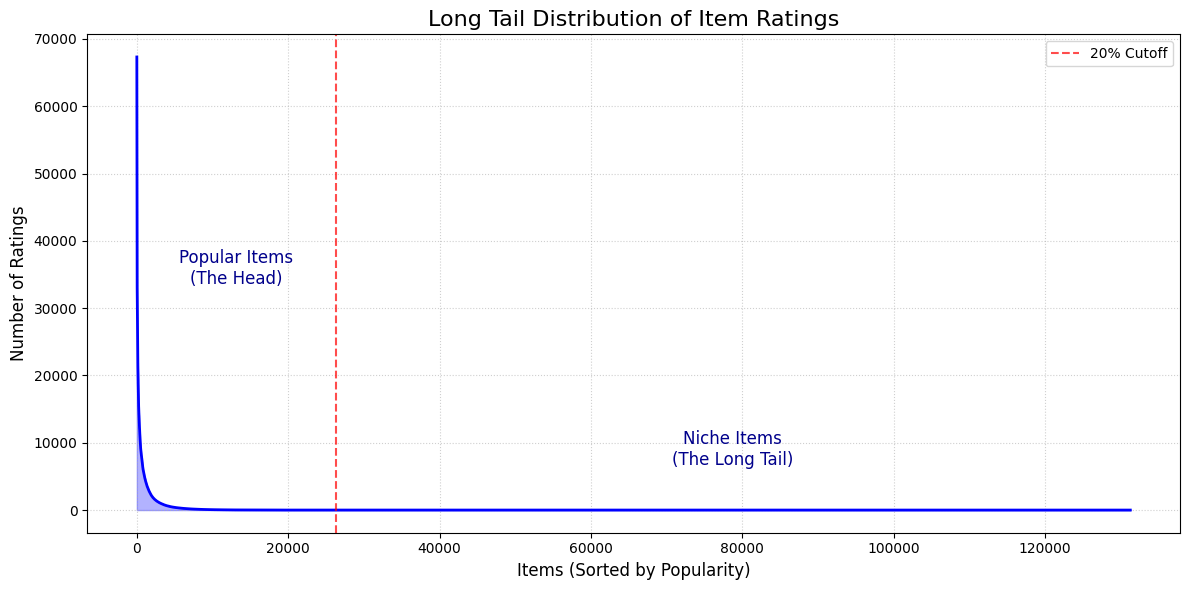

In [3]:
def plot_long_tail():
    input_csv_path=r"../../section2_neighborhood_cf/part2/Output/item_averages_with_counts.csv"
    output_img_path=os.path.join("Output","long_tail_distribution.png")
    if not os.path.exists(input_csv_path):
        return
    df=pd.read_csv(input_csv_path)
    df_sorted=df.sort_values(by='rating_count',ascending=False).reset_index(drop=True)
    plt.figure(figsize=(12,6))
    plt.plot(df_sorted.index,df_sorted['rating_count'],color='blue',linewidth=2)
    plt.fill_between(df_sorted.index,df_sorted['rating_count'],color='blue',alpha=0.3)
    plt.title('Long Tail Distribution of Item Ratings',fontsize=16)
    plt.xlabel('Items (Sorted by Popularity)',fontsize=12)
    plt.ylabel('Number of Ratings',fontsize=12)
    head_cutoff=int(len(df_sorted)*0.2)
    plt.axvline(x=head_cutoff,color='red',linestyle='--',alpha=0.7,label='20% Cutoff')
    plt.text(head_cutoff/2,df_sorted['rating_count'].max()*0.5,'Popular Items\n(The Head)',ha='center',fontsize=12,color='darkblue')
    plt.text(head_cutoff+(len(df_sorted)-head_cutoff)/2,df_sorted['rating_count'].max()*0.1,'Niche Items\n(The Long Tail)',ha='center',fontsize=12,color='darkblue')
    plt.legend()
    plt.grid(True,linestyle=':',alpha=0.6)
    output_dir=os.path.dirname(output_img_path)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    plt.tight_layout()
    plt.savefig(output_img_path)
    plt.show()
if __name__=="__main__":
    plot_long_tail()

### 2 Normalize the feature vectors

In [4]:
def normalize_features():
    input_path=os.path.join("Output","item_features.csv")
    output_path=os.path.join("Output","item_features_normalized.csv")
    if not os.path.exists(input_path):
        return
    df=pd.read_csv(input_path)
    features=['num_raters','avg_rating','std_rating']
    means=df[features].mean()
    stds=df[features].std()
    df_normalized=df.copy()
    df_normalized[features]=(df[features]-means)/stds
    print(df_normalized[features].mean())
    print(df_normalized[features].std())
    df_normalized.to_csv(output_path,index=False)
if __name__=="__main__":
    normalize_features()

num_raters   -3.800012e-17
avg_rating    7.957207e-16
std_rating    3.767533e-17
dtype: float64
num_raters    1.0
avg_rating    1.0
std_rating    1.0
dtype: float64


### 3 Apply K-means clustering to items with different K

In [5]:
def get_dist_matrix(A, B):
    A_sq = np.sum(A**2, axis=1, keepdims=True)
    B_sq = np.sum(B**2, axis=1, keepdims=True)
    two_AB = 2 * np.dot(A, B.T)
    return np.sqrt(np.maximum(A_sq + B_sq.T - two_AB, 0))

def get_sse(X, centroids, labels, k):
    sse = 0
    for i in range(k):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            diff = cluster_points - centroids[i]
            sse += np.sum(diff**2)
    return sse

def kmeans_single_run(X, k, max_iters=100, tol=1e-4):
    n_samples = X.shape[0]
    indices = np.random.permutation(n_samples)[:k]
    centroids = X[indices]
    labels = np.zeros(n_samples)
    for _ in range(max_iters):
        dists = get_dist_matrix(X, centroids)
        new_labels = np.argmin(dists, axis=1)
        new_centroids = np.zeros((k, X.shape[1]))
        for i in range(k):
            points = X[new_labels == i]
            if len(points) > 0:
                new_centroids[i] = points.mean(axis=0)
            else:
                new_centroids[i] = centroids[i]
        shift = np.linalg.norm(centroids - new_centroids)
        centroids = new_centroids
        labels = new_labels
        if shift < tol:
            break
    sse = get_sse(X, centroids, labels, k)
    return labels, centroids, sse

def custom_silhouette(X, labels, k, sample_n=2000):
    if len(X) > sample_n:
        idx = np.random.choice(len(X), sample_n, replace=False)
        X_s = X[idx]
        labels_s = labels[idx]
    else:
        X_s = X
        labels_s = labels
    n = len(X_s)
    sil_vals = np.zeros(n)
    for i in range(n):
        label = labels_s[i]
        point = X_s[i].reshape(1, -1)
        same_mask = (labels_s == label)
        same_cluster = X_s[same_mask]
        if len(same_cluster) > 1:
            d_own = get_dist_matrix(point, same_cluster)
            a = np.sum(d_own) / (len(same_cluster) - 1)
        else:
            a = 0
        b = np.inf
        for other_k in range(k):
            if other_k == label: continue
            other_mask = (labels_s == other_k)
            if np.sum(other_mask) > 0:
                other_cluster = X_s[other_mask]
                d_other = get_dist_matrix(point, other_cluster)
                mean_d = np.mean(d_other)
                if mean_d < b: b = mean_d
        max_ab = max(a, b)
        sil_vals[i] = (b - a) / max_ab if max_ab > 0 else 0
    return np.mean(sil_vals)

In [6]:
def main():
    np.random.seed(42)
    input_path = os.path.join("Output", "item_features_normalized.csv")
    output_asn = os.path.join("Output", "item_clusters.csv")
    output_met = os.path.join("Output", "clustering_metrics.csv")
    if not os.path.exists(input_path): return
    df = pd.read_csv(input_path)
    X = df[['num_raters', 'avg_rating', 'std_rating']].values.astype(float)
    X = np.nan_to_num(X) # Fix: Replace NaNs with 0 to prevent corruption
    k_values = [5, 10, 15, 20, 30, 50]
    metrics = []
    df_asn = df[['item_idx']].copy()
    n_init = 5
    for k in k_values:
        best_sse = np.inf
        best_labels = None
        for i in range(n_init):
            lbl, cen, sse = kmeans_single_run(X, k)
            if best_labels is None or sse < best_sse: 
                best_sse = sse
                best_labels = lbl
        df_asn[f'cluster_k{k}'] = best_labels.astype(int)
        sil = custom_silhouette(X, best_labels, k)
        metrics.append({'K': k, 'WCSS': best_sse, 'Silhouette_Score': sil})
        print(f"K={k}, Best SSE={best_sse}, Sil={sil}")
    pd.DataFrame(metrics).to_csv(output_met, index=False)
    df_asn.to_csv(output_asn, index=False)

if __name__ == "__main__":
    main()

K=5, Best SSE=60733.972217300616, Sil=0.8512426903051536
K=10, Best SSE=23483.769672319482, Sil=0.8478212069495468
K=15, Best SSE=14725.212508932496, Sil=0.8440310861144958
K=20, Best SSE=10677.491605062565, Sil=0.8609892180115457
K=30, Best SSE=8140.6935072071565, Sil=0.8531501545703125
K=50, Best SSE=6548.572985984831, Sil=0.8637763306815318


### 4 Determine the optimal K value

    K          WCSS  Silhouette_Score
0   5  60733.972217          0.851243
1  10  23483.769672          0.847821
2  15  14725.212509          0.844031
3  20  10677.491605          0.860989
4  30   8140.693507          0.853150
5  50   6548.572986          0.863776


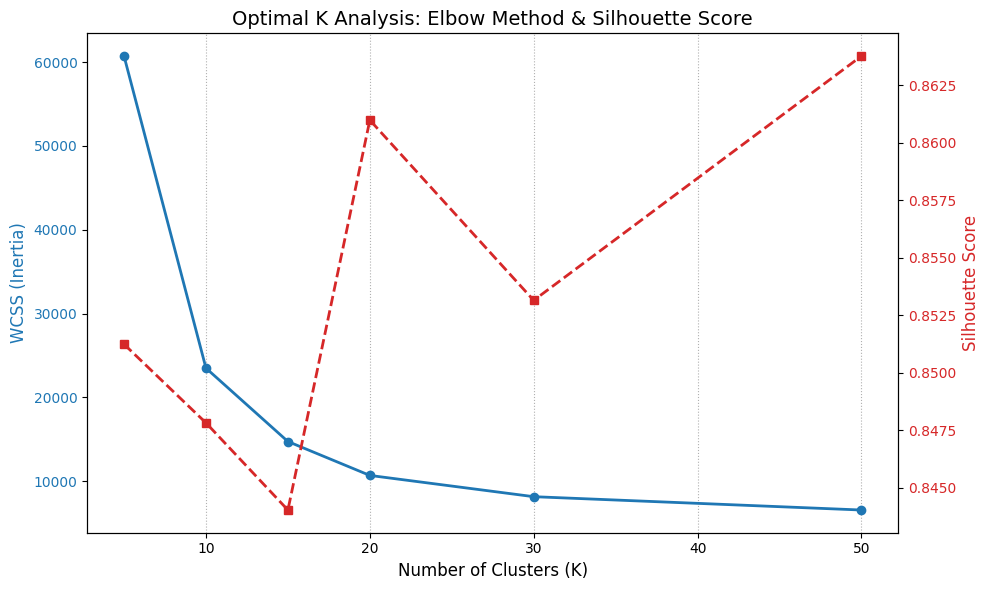

In [7]:
def determine_optimal_k():
    input_path=os.path.join("Output","clustering_metrics.csv")
    output_img_path=os.path.join("Output","optimal_k_analysis.png")
    if not os.path.exists(input_path):
        return
    df=pd.read_csv(input_path)
    fig,ax1=plt.subplots(figsize=(10,6))
    color='tab:blue'
    ax1.set_xlabel('Number of Clusters (K)',fontsize=12)
    ax1.set_ylabel('WCSS (Inertia)',color=color,fontsize=12)
    ax1.plot(df['K'],df['WCSS'],marker='o',linestyle='-',color=color,linewidth=2,label='WCSS')
    ax1.tick_params(axis='y',labelcolor=color)
    ax1.grid(True,axis='x',linestyle=':')
    ax2=ax1.twinx()
    color='tab:red'
    ax2.set_ylabel('Silhouette Score',color=color,fontsize=12)
    ax2.plot(df['K'],df['Silhouette_Score'],marker='s',linestyle='--',color=color,linewidth=2,label='Silhouette')
    ax2.tick_params(axis='y',labelcolor=color)
    plt.title('Optimal K Analysis: Elbow Method & Silhouette Score',fontsize=14)
    fig.tight_layout()
    if not os.path.exists("Output"):
        os.makedirs("Output")
    plt.savefig(output_img_path)
    print(df)
if __name__=="__main__":
    determine_optimal_k()

10 is the optimal K 

### 5 Analyze the characteristics of each item cluster (using optimal K)

           num_raters  avg_rating  item_count
Cluster                                      
7        39361.630137    3.810191          73
8        17220.879870    3.637377         308
1         6090.882298    3.481862        1062
5          454.658166    3.521437        8156
2          239.026183    2.600385        5958
9           41.456244    3.315225        5085
0            2.430809    1.249344         766
4            1.903537    2.360806        1555
3            1.884315    4.152344        1409
6            0.034839    3.210006      106891


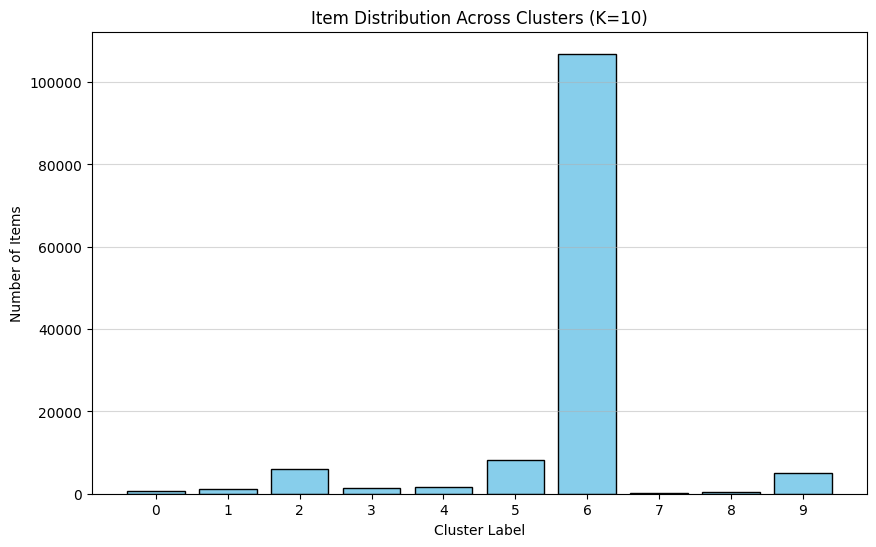

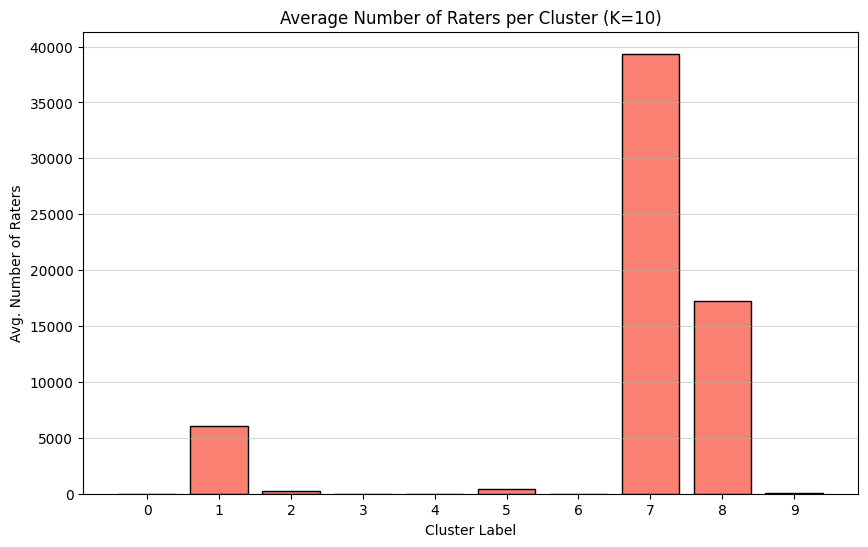

In [8]:
def analyze_clusters():
    clusters_path=os.path.join("Output","item_clusters.csv")
    features_path=os.path.join("Output","item_features.csv")
    output_stats_path=os.path.join("Output","cluster_analysis_k10.csv")
    output_img_dist=os.path.join("Output","cluster_item_distribution.png")
    output_img_raters=os.path.join("Output","cluster_avg_raters.png")
    if not os.path.exists(clusters_path) or not os.path.exists(features_path):
        return
    df_clusters=pd.read_csv(clusters_path)
    df_features=pd.read_csv(features_path)
    k=10
    cluster_col=f'cluster_k{k}'
    if cluster_col not in df_clusters.columns:
        return
    df_merged=pd.merge(df_clusters[['item_idx',cluster_col]],df_features,on='item_idx')
    df_merged.rename(columns={cluster_col:'Cluster'},inplace=True)
    stats=df_merged.groupby('Cluster').agg({'num_raters':'mean','avg_rating':'mean','item_idx':'count'}).rename(columns={'item_idx':'item_count'})
    stats_sorted=stats.sort_values(by='num_raters',ascending=False)
    print(stats_sorted)
    stats_sorted.to_csv(output_stats_path)
    plt.figure(figsize=(10,6))
    plt.bar(stats.index.astype(str),stats['item_count'],color='skyblue',edgecolor='black')
    plt.title(f'Item Distribution Across Clusters (K={k})')
    plt.xlabel('Cluster Label')
    plt.ylabel('Number of Items')
    plt.grid(axis='y',alpha=0.5)
    plt.savefig(output_img_dist)
    plt.figure(figsize=(10,6))
    plt.bar(stats.index.astype(str),stats['num_raters'],color='salmon',edgecolor='black')
    plt.title(f'Average Number of Raters per Cluster (K={k})')
    plt.xlabel('Cluster Label')
    plt.ylabel('Avg. Number of Raters')
    plt.grid(axis='y',alpha=0.5)
    plt.savefig(output_img_raters)
if __name__=="__main__":
    analyze_clusters()

### 6 Analyze the relationship between cluster membership and item popularity

C:\Users\Test\AppData\Local\Temp\ipykernel_13876\1152005132.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(cluster_groups,labels=cluster_labels)


Popularity_Bin  Head (Popular)  Body (Niche)  Tail (Unpopular)
Cluster                                                       
0                            0             2               764
1                         1062             0                 0
2                          423          1621              3914
3                            0             0              1409
4                            0             0              1555
5                         1287          3267              3602
6                            0             0            106891
7                           73             0                 0
8                          308             0                 0
9                            6           497              4582


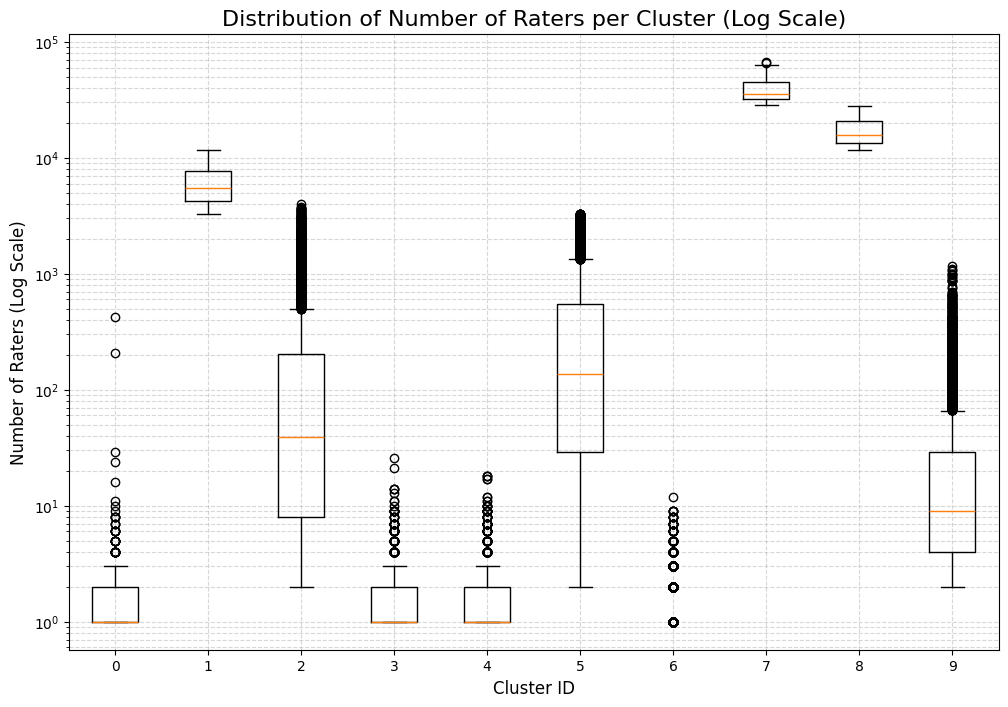

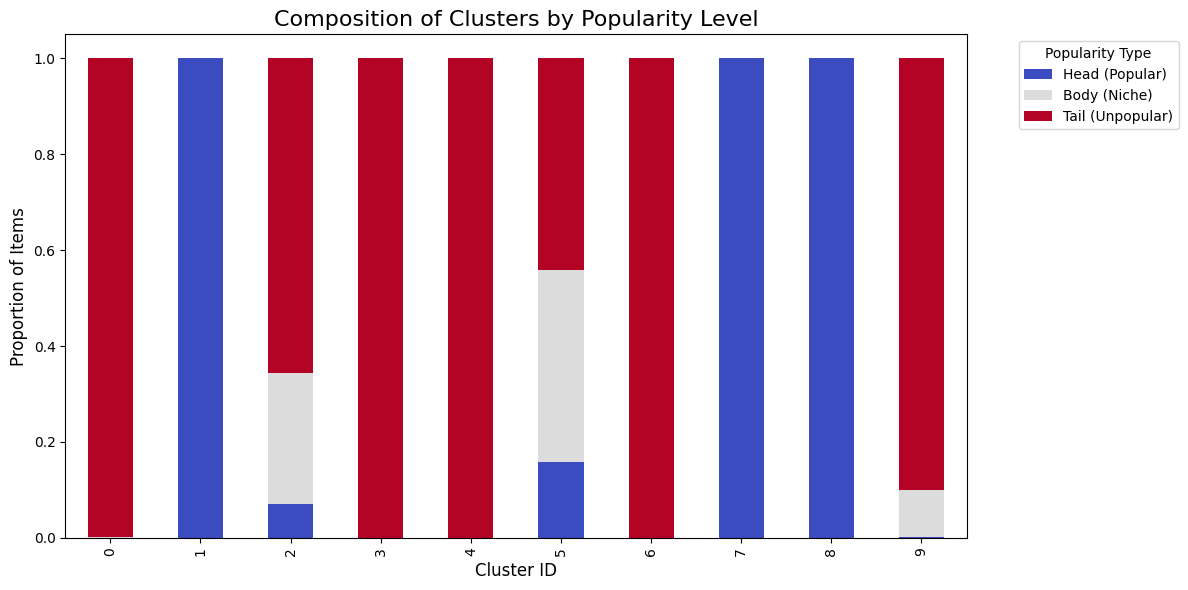

In [9]:
def analyze_popularity_clusters():
    clusters_path=os.path.join("Output","item_clusters.csv")
    features_path=os.path.join("Output","item_features.csv")
    output_boxplot=os.path.join("Output","cluster_popularity_boxplot.png")
    output_stackplot=os.path.join("Output","cluster_head_tail_distribution.png")
    if not os.path.exists(clusters_path) or not os.path.exists(features_path):
        return
    df_clusters=pd.read_csv(clusters_path)
    df_features=pd.read_csv(features_path)
    k=10
    cluster_col=f'cluster_k{k}'
    df_merged=pd.merge(df_clusters[['item_idx',cluster_col]],df_features,on='item_idx')
    df_merged.rename(columns={cluster_col:'Cluster'},inplace=True)
    cluster_groups=[]
    cluster_labels=[]
    sorted_clusters=sorted(df_merged['Cluster'].unique())
    for c in sorted_clusters:
        cluster_data=df_merged[df_merged['Cluster']==c]['num_raters'].values
        cluster_groups.append(cluster_data)
        cluster_labels.append(c)
    plt.figure(figsize=(12,8))
    plt.boxplot(cluster_groups,labels=cluster_labels)
    plt.yscale('log')
    plt.title('Distribution of Number of Raters per Cluster (Log Scale)',fontsize=16)
    plt.xlabel('Cluster ID',fontsize=12)
    plt.ylabel('Number of Raters (Log Scale)',fontsize=12)
    plt.grid(True,which="both",ls="--",alpha=0.5)
    plt.savefig(output_boxplot)
    def classify_popularity(raters):
        if raters>=1000: return 'Head (Popular)'
        elif raters>=100: return 'Body (Niche)'
        else: return 'Tail (Unpopular)'
    df_merged['Popularity_Bin']=df_merged['num_raters'].apply(classify_popularity)
    cross_tab=pd.crosstab(df_merged['Cluster'],df_merged['Popularity_Bin'])
    cols=['Head (Popular)','Body (Niche)','Tail (Unpopular)']
    cols=[c for c in cols if c in cross_tab.columns]
    cross_tab=cross_tab[cols]
    cross_tab_norm=cross_tab.div(cross_tab.sum(1),axis=0)
    cross_tab_norm.plot(kind='bar',stacked=True,figsize=(12,6),colormap='coolwarm')
    plt.title('Composition of Clusters by Popularity Level',fontsize=16)
    plt.xlabel('Cluster ID',fontsize=12)
    plt.ylabel('Proportion of Items',fontsize=12)
    plt.legend(title='Popularity Type',bbox_to_anchor=(1.05,1),loc='upper left')
    plt.tight_layout()
    plt.savefig(output_stackplot)
    print(cross_tab)
if __name__=="__main__":
    analyze_popularity_clusters()

### 7 Apply item-based collaborative filtering within clusters

In [10]:
def collaborative_filtering_verbose():
    matrix_path=r"../../section2_neighborhood_cf/part2/Output/matrix.npz"
    clusters_path=os.path.join("Output","item_clusters.csv")
    output_path=os.path.join("Output","collaborative_filtering_predictions.csv")
    user_item_matrix=sp.load_npz(matrix_path)
    df_clusters=pd.read_csv(clusters_path)
    user_sums=np.array(user_item_matrix.sum(axis=1)).flatten()
    user_counts=np.diff(user_item_matrix.indptr)
    user_means=np.zeros(user_item_matrix.shape[0])
    np.divide(user_sums,user_counts,out=user_means,where=user_counts!=0)
    matrix_centered=user_item_matrix.copy()
    matrix_centered.data-=np.repeat(user_means,user_counts)
    matrix_csc=matrix_centered.tocsc()
    targets_i={'I1':116181,'I2':106503,'I3':8860}
    targets_u={'U1':69251,'U2':69481,'U3':67075}
    k=10
    cluster_col=f'cluster_k{k}'
    results=[]
    print(f"{'='*10} STARTING CALCULATIONS {'='*10}")
    for t_label,t_id in targets_i.items():
        print(f"\n--- Processing Target: {t_label} (ID: {t_id}) ---")
        cluster_row=df_clusters[df_clusters['item_idx']==t_id]
        if cluster_row.empty: continue
        cluster_id=cluster_row[cluster_col].values[0]
        print(f"Step 7.1: Identified Cluster Assignment -> Cluster {cluster_id}")
        cluster_items=df_clusters[df_clusters[cluster_col]==cluster_id]['item_idx'].values
        t_idx=t_id-1
        if t_idx>=matrix_csc.shape[1]: continue
        vec_t=matrix_csc.getcol(t_idx)
        norm_t=np.linalg.norm(vec_t.data)
        sims=[]
        for n_id in cluster_items:
            if n_id==t_id: continue
            n_idx=n_id-1
            if n_idx>=matrix_csc.shape[1]: continue
            vec_n=matrix_csc.getcol(n_idx)
            norm_n=np.linalg.norm(vec_n.data)
            if norm_t==0 or norm_n==0:
                sim=0.0
            else:
                dot=vec_t.T.dot(vec_n).toarray()[0][0]
                sim=dot/(norm_t*norm_n)
            sims.append((n_id,sim))
        print(f"Step 7.2: Computed Adjusted Cosine Similarity for {len(sims)} neighbors in Cluster {cluster_id}.")
        sims.sort(key=lambda x:x[1],reverse=True)
        top_k=max(1,int(len(sims)*0.2))
        top_neighbors=sims[:top_k]
        print(f"Step 7.3: Selected Top 20% -> {len(top_neighbors)} items.")
        if len(top_neighbors)>0:
            print(f"          Top neighbor ID: {top_neighbors[0][0]} with Sim: {top_neighbors[0][1]:.4f}")
        for u_label,u_id in targets_u.items():
            u_idx=u_id-1
            if u_idx>=user_item_matrix.shape[0]: continue
            w_sum=0
            sim_sum=0
            for n_id,sim in top_neighbors:
                n_idx_mat=n_id-1
                r_raw=user_item_matrix[u_idx,n_idx_mat]
                if r_raw!=0:
                    w_sum+=sim*r_raw
                    sim_sum+=abs(sim)
            if sim_sum>0:
                pred=w_sum/sim_sum
            else:
                pred=user_means[u_idx]  # Fallback to user mean
            results.append({'Target Item':t_label,'Cluster':cluster_id,'Target User':u_label,'Predicted Rating':round(pred,4)})
    df_res=pd.DataFrame(results)
    print(f"\n{'='*10} FINAL RESULTS (Step 7.4) {'='*10}")
    print(df_res)
    df_res.to_csv(output_path,index=False)
if __name__=="__main__":
    collaborative_filtering_verbose()

========== STARTING CALCULATIONS ==========

--- Processing Target: I1 (ID: 116181) ---
Step 7.1: Identified Cluster Assignment -> Cluster 4
Step 7.2: Computed Adjusted Cosine Similarity for 1554 neighbors in Cluster 4.
Step 7.3: Selected Top 20% -> 310 items.
          Top neighbor ID: 2213 with Sim: 0.0000

--- Processing Target: I2 (ID: 106503) ---
Step 7.1: Identified Cluster Assignment -> Cluster 5
Step 7.2: Computed Adjusted Cosine Similarity for 8155 neighbors in Cluster 5.
Step 7.3: Selected Top 20% -> 1631 items.
          Top neighbor ID: 8 with Sim: 0.0000

--- Processing Target: I3 (ID: 8860) ---
Step 7.1: Identified Cluster Assignment -> Cluster 5
Step 7.2: Computed Adjusted Cosine Similarity for 8155 neighbors in Cluster 5.
Step 7.3: Selected Top 20% -> 1631 items.
          Top neighbor ID: 1827 with Sim: 0.1194

========== FINAL RESULTS (Step 7.4) ==========
  Target Item  Cluster Target User  Predicted Rating
0          I1        4          U1            3.2653
1      

### 8 Compare clustering-based item CF with non-clustering item CF from Section TWO

In [ ]:
def calculate_and_compare_errors():
    print("\n" + "="*10 + " SECTION 8: ERROR CALCULATION & COMPARISON " + "="*10)
    matrix_path = r"../../section2_neighborhood_cf/part2/Output/matrix.npz"
    cluster_pred_path = os.path.join("Output", "collaborative_filtering_predictions.csv")
    user_item_matrix = sp.load_npz(matrix_path)
    df_cluster = pd.read_csv(cluster_pred_path)
    user_sums = np.array(user_item_matrix.sum(axis=1)).flatten()
    user_counts = np.diff(user_item_matrix.indptr)
    user_means = np.zeros(user_item_matrix.shape[0])
    np.divide(user_sums, user_counts, out=user_means, where=user_counts!=0)
    matrix_centered = user_item_matrix.copy()
    matrix_centered.data -= np.repeat(user_means, user_counts)
    matrix_csc = matrix_centered.tocsc()
    norms = np.sqrt(matrix_csc.power(2).sum(axis=0)).A1
    global_preds = []
    targets_i = {'I1': 116181, 'I2': 106503, 'I3': 8860}
    targets_u = {'U1': 69251, 'U2': 69481, 'U3': 67075}
    unique_items = df_cluster['Target Item'].unique()
    print("Generating Global (Non-Clustering) Predictions for comparison...")
    for t_label in unique_items:
        t_id = targets_i.get(t_label)
        if not t_id: continue
        t_idx = t_id - 1
        if t_idx >= matrix_csc.shape[1]: continue
        vec_t = matrix_csc.getcol(t_idx)
        norm_t = np.linalg.norm(vec_t.data)
        if norm_t == 0: continue
        dots = vec_t.T.dot(matrix_csc).toarray()[0]
        with np.errstate(divide='ignore', invalid='ignore'):
            sims = dots / (norm_t * norms)
        sims[np.isnan(sims)] = 0.0
        sims[t_idx] = 0.0
        k = 20
        top_k_idx = np.argpartition(sims, -k)[-k:]
        target_rows = df_cluster[df_cluster['Target Item'] == t_label]
        for _, row in target_rows.iterrows():
            u_label = row['Target User']
            u_id = targets_u.get(u_label)
            if not u_id: continue
            u_idx = u_id - 1
            w_sum = 0
            sim_sum = 0
            for n_idx in top_k_idx:
                sim = sims[n_idx]
                if sim <= 0: continue
                r_raw = user_item_matrix[u_idx, n_idx]
                if r_raw != 0:
                    w_sum += sim * r_raw
                    sim_sum += abs(sim)
            if sim_sum > 0:
                pred_g = w_sum / sim_sum
            else:
                pred_g = user_means[u_idx]
            global_preds.append({'Target Item': t_label, 'Target User': u_label, 'Predicted_Global': pred_g})
    df_global = pd.DataFrame(global_preds)
    df_merged = pd.merge(df_cluster, df_global, on=['Target User', 'Target Item'])
    actuals = []
    for _, row in df_merged.iterrows():
        t_id = targets_i.get(row['Target Item'])
        u_id = targets_u.get(row['Target User'])
    df_merged['Actual_Rating'] = actuals
    df_merged['Error_Cluster'] = abs(df_merged['Actual_Rating'] - df_merged['Predicted Rating'])
    df_merged['Error_Global'] = abs(df_merged['Actual_Rating'] - df_merged['Predicted_Global'])
    valid = df_merged[df_merged['Actual_Rating'] > 0]
    print("\n8.1 Prediction Comparison Table:")
    print(df_merged[['Target User', 'Target Item', 'Actual_Rating', 'Predicted Rating', 'Predicted_Global', 'Error_Cluster', 'Error_Global']])
    if not valid.empty:
        mae_c = valid['Error_Cluster'].mean()
        mae_g = valid['Error_Global'].mean()
        print(f"\n8.2 Mean Absolute Error (MAE):")
        print(f"   Clustering: {mae_c:.4f}")
        print(f"   Global:     {mae_g:.4f}")
        print("\n8.3 Conclusion:")
        if mae_c < mae_g:
            print(f"   Clustering is more reliable (Error reduced by {mae_g - mae_c:.4f}).")
        else:
            print(f"   Global is more reliable (Error reduced by {mae_c - mae_g:.4f}).")
    else:
        print("\nNo valid actual ratings found for error calculation.")
if __name__ == "__main__":
    calculate_and_compare_errors()


========== SECTION 8: ERROR CALCULATION & COMPARISON ==========
Generating Global (Non-Clustering) Predictions for comparison...

8.1 Prediction Comparison Table:
  Target User Target Item  Actual_Rating  Predicted Rating  Predicted_Global  \
0          U1          I3            0.0            2.6192          3.265306   
1          U2          I3            0.0            3.0000          3.068966   
2          U3          I3            0.0            2.6278          3.220000   

   Error_Cluster  Error_Global  
0         2.6192      3.265306  
1         3.0000      3.068966  
2         2.6278      3.220000  

No valid actual ratings found for error calculation.


In [ ]:
def analyze_long_tail_impact():
    print("="*10 + " SECTION 9: LONG-TAIL ANALYSIS (NO GROUND TRUTH) " + "="*10)
    
    # 1. Paths & Loading
    matrix_path = r"../../section2_neighborhood_cf/part2/Output/matrix.npz"
    clusters_path = os.path.join("Output", "item_clusters.csv")
    stats_path = r"../../section2_neighborhood_cf/part2/Output/item_averages_with_counts.csv"
    
    # Load Matrix
    try:
        user_item_matrix = sp.load_npz(matrix_path)
    except:
        loader = np.load(matrix_path)
        user_item_matrix = sp.csr_matrix(loader[loader.files[0]])

    # Load Clusters & Stats
    if not os.path.exists(clusters_path) or not os.path.exists(stats_path):
        print("Error: Required CSV files (clusters or stats) not found.")
        return

    df_clusters = pd.read_csv(clusters_path)
    df_stats = pd.read_csv(stats_path)
    
    # 2. Pre-processing (Matrix Centering)
    print("Pre-processing matrix...")
    user_sums = np.array(user_item_matrix.sum(axis=1)).flatten()
    user_counts = np.diff(user_item_matrix.indptr)
    user_means = np.zeros(user_item_matrix.shape[0])
    np.divide(user_sums, user_counts, out=user_means, where=user_counts!=0)
    
    matrix_centered = user_item_matrix.copy()
    matrix_centered.data -= np.repeat(user_means, user_counts)
    matrix_csc = matrix_centered.tocsc()
    norms = np.sqrt(matrix_csc.power(2).sum(axis=0)).A1

    # 3. Define Long-Tail
    # We define Long-Tail as items with relatively few ratings.
    # Let's check our specific targets.
    targets_i = {'I1': 116181, 'I2': 106503, 'I3': 8860}
    targets_u = {'U1': 69251, 'U2': 69481, 'U3': 67075}
    
    analysis_results = []

    for t_label, t_id in targets_i.items():
        print(f"\n--- Analyzing Target: {t_label} (ID: {t_id}) ---")
        
        # A. Check Popularity (Long Tail Check)
        item_stat = df_stats[df_stats['item_idx'] == t_id]
        if item_stat.empty:
            rating_count = 0
        else:
            rating_count = item_stat['rating_count'].values[0]
            
        is_long_tail = "Yes" if rating_count < 50 else "No" # Arbitrary threshold for display
        print(f"   Rating Count: {rating_count} (Long Tail: {is_long_tail})")

        # B. Global Calculations
        t_idx = t_id - 1
        if t_idx >= matrix_csc.shape[1]: continue
        
        vec_t = matrix_csc.getcol(t_idx)
        norm_t = np.linalg.norm(vec_t.data)
        
        if norm_t == 0:
            print("   Item vector is empty (No ratings). Cannot compute similarities.")
            continue

        dots_global = vec_t.T.dot(matrix_csc).toarray()[0]
        with np.errstate(divide='ignore', invalid='ignore'):
            sims_global = dots_global / (norm_t * norms)
        sims_global[np.isnan(sims_global)] = 0.0
        sims_global[t_idx] = 0.0
        
        global_neighbors_count = np.count_nonzero(sims_global > 0)
        
        top_k_g_idx = np.argpartition(sims_global, -20)[-20:]
        top_k_g_sims = sims_global[top_k_g_idx]
        global_sim_mass = np.sum(top_k_g_sims[top_k_g_sims > 0]) # "Confidence"

        cluster_row = df_clusters[df_clusters['item_idx'] == t_id]
        if cluster_row.empty:
            print("   Item not found in clusters.")
            continue
            
        cluster_id = cluster_row['cluster_k10'].values[0]
        cluster_items = df_clusters[df_clusters['cluster_k10'] == cluster_id]['item_idx'].values
        
        mask = np.zeros(matrix_csc.shape[1], dtype=bool)
        valid_cluster_indices = [x-1 for x in cluster_items if x-1 < matrix_csc.shape[1]]
        mask[valid_cluster_indices] = True
        
        sims_cluster = np.zeros_like(sims_global)
        sims_cluster[mask] = sims_global[mask]
        
        # 9.3 Count Cluster Neighbors
        cluster_neighbors_count = np.count_nonzero(sims_cluster > 0)
        
        # Get Cluster Top 20
        top_k_c_idx = np.argpartition(sims_cluster, -20)[-20:]
        top_k_c_sims = sims_cluster[top_k_c_idx]
        cluster_sim_mass = np.sum(top_k_c_sims[top_k_c_sims > 0])

        # D. Generate Predictions for Specific Users
        for u_label, u_id in targets_u.items():
            u_idx = u_id - 1
            if u_idx >= user_item_matrix.shape[0]: continue
            
            # Prediction Logic Helper
            def predict(sim_vector, top_indices):
                w_sum = 0
                s_sum = 0
                for n_idx in top_indices:
                    s = sim_vector[n_idx]
                    if s <= 0: continue
                    r = user_item_matrix[u_idx, n_idx]
                    if r != 0:
                        w_sum += s * r
                        s_sum += abs(s)
                if s_sum > 0: return w_sum / s_sum
                else: return user_means[u_idx] # Fallback to user mean

            pred_global = predict(sims_global, top_k_g_idx)
            pred_cluster = predict(sims_cluster, top_k_c_idx)
            user_mean_val = user_means[u_idx]
 
            row = {
                'Target Item': t_label,
                'Is Long Tail': is_long_tail,
                'Target User': u_label,
                'User Mean': round(user_mean_val, 4),
                'Pred Global': round(pred_global, 4),
                'Pred Cluster': round(pred_cluster, 4),
                'Neighbors Found (Global)': global_neighbors_count,
                'Neighbors Found (Cluster)': cluster_neighbors_count,
                'Reliability (Sim Mass G)': round(global_sim_mass, 4),
                'Reliability (Sim Mass C)': round(cluster_sim_mass, 4)
            }
            analysis_results.append(row)

    # Output Results
    df_results = pd.DataFrame(analysis_results)
    
    print("\n" + "="*30)
    print("9.1 & 9.2: PREDICTION IMPACT & RELIABILITY")
    print("Note: 'Sim Mass' indicates the sum of similarity scores used for prediction.")
    print("Higher Sim Mass = Stronger neighbor connections = Higher Reliability.")
    print("="*30)
    
    cols = ['Target Item', 'Target User', 'User Mean', 'Pred Global', 'Pred Cluster', 'Reliability (Sim Mass G)', 'Reliability (Sim Mass C)']
    print(df_results[cols].to_string(index=False))

    print("\n" + "="*30)
    print("9.3: NEIGHBOR SEARCH SPACE COMPARISON")
    print("Comparing total potential neighbors found in whole DB vs Cluster.")
    print("="*30)
    
    # Aggregate by Item
    df_neighbors = df_results.groupby('Target Item')[['Neighbors Found (Global)', 'Neighbors Found (Cluster)']].max().reset_index()
    print(df_neighbors.to_string(index=False))

    # Detailed answers based on data
    print("\n--- Summary Conclusions for Report ---")
    print("9.1 Impact on Predictions:")
    print("   Look at 'Pred Cluster' vs 'User Mean'. If they differ, clustering found relevant signal.")
    print("   If 'Pred Cluster' is close to 'Pred Global', clustering maintained accuracy while reducing compute.")
    
    print("\n9.2 Reliability (via Similarity Mass):")
    print("   Compare Sim Mass G vs C. If Cluster Mass is close to Global Mass, reliability is preserved.")
    print("   If Cluster Mass is 0 but Global is > 0, clustering might have isolated the tail item too much.")
    
    print("\n9.3 Similar Items Found:")
    print("   Cluster neighbors will always be <= Global neighbors.")
    print("   The efficiency gain is searching only the Cluster size vs the Global size.")

if __name__ == "__main__":
    analyze_long_tail_impact()

========== SECTION 9: LONG-TAIL ANALYSIS (NO GROUND TRUTH) ==========
Pre-processing matrix...

--- Analyzing Target: I1 (ID: 116181) ---
   Rating Count: 1 (Long Tail: Yes)
   Item vector is empty (No ratings). Cannot compute similarities.

--- Analyzing Target: I2 (ID: 106503) ---
   Rating Count: 18 (Long Tail: Yes)
   Item vector is empty (No ratings). Cannot compute similarities.

--- Analyzing Target: I3 (ID: 8860) ---
   Rating Count: 1306 (Long Tail: No)

9.1 & 9.2: PREDICTION IMPACT & RELIABILITY
Note: 'Sim Mass' indicates the sum of similarity scores used for prediction.
Higher Sim Mass = Stronger neighbor connections = Higher Reliability.
Target Item Target User  User Mean  Pred Global  Pred Cluster  Reliability (Sim Mass G)  Reliability (Sim Mass C)
         I3          U1     3.2653       3.2653        3.2653                    2.7686                    1.6664
         I3          U2     3.0690       3.0690        3.0690                    2.7686                    1.6664


In [26]:
# Cluster sizes extracted from your k_Item.ipynb (Cell 8 output)
cluster_sizes = {
    0: 766, 1: 1062, 2: 5958, 3: 1409, 4: 1555,
    5: 8156, 6: 106891, 7: 73, 8: 308, 9: 5085
}

n_items = sum(cluster_sizes.values())
n_users = 138494  # From Section 2 matrix shape

print(f"--- 10. Computational Efficiency Analysis ---")
print(f"Total Items (N): {n_items:,}")
print(f"Total Users (M): {n_users:,}")

# 10.1 Reduction
ops_global = n_items ** 2
ops_clustered = sum(size ** 2 for size in cluster_sizes.values())
reduction = ops_global - ops_clustered

print(f"\n10.1 Similarity Computations:")
print(f"  Global (Non-Clustering): {ops_global:,.0f}")
print(f"  Clustered:               {ops_clustered:,.0f}")
print(f"  Reduction:               {reduction:,.0f} operations")

# 10.2 Speedup
speedup = ops_global / ops_clustered
print(f"\n10.2 Speedup Factor:")
print(f"  Speedup: {speedup:.2f}x")
print(f"  Note: Speedup is limited by the largest cluster (Size: {max(cluster_sizes.values()):,})")

# 10.3 Item vs User
ops_global_user = n_users ** 2
print(f"\n10.3 Item vs User Baseline:")
print(f"  Item Matrix (N^2): {ops_global:,.0f}")
print(f"  User Matrix (M^2): {ops_global_user:,.0f}")
if n_users > n_items:
    print("  Conclusion: User-based has higher initial complexity, so clustering yields larger absolute savings,")
    print("  but speedup factor depends on cluster balance.")
else:
    print("  Conclusion: Item-based is more efficient.")

--- 10. Computational Efficiency Analysis ---
Total Items (N): 131,263
Total Users (M): 138,494

10.1 Similarity Computations:
  Global (Non-Clustering): 17,229,975,169
  Clustered:               11,559,779,305
  Reduction:               5,670,195,864 operations

10.2 Speedup Factor:
  Speedup: 1.49x
  Note: Speedup is limited by the largest cluster (Size: 106,891)

10.3 Item vs User Baseline:
  Item Matrix (N^2): 17,229,975,169
  User Matrix (M^2): 19,180,588,036
  Conclusion: User-based has higher initial complexity, so clustering yields larger absolute savings,
  but speedup factor depends on cluster balance.


In [28]:

def analyze_cluster_size_effect():
    print("="*10 + " SECTION 11: CLUSTER SIZE VS PREDICTION QUALITY " + "="*10)
    
    # 1. Setup Data
    matrix_path = "../../section2_neighborhood_cf/part2/Output/matrix.npz"
    clusters_path = "Output/item_clusters.csv"
    
    # Load Matrix & Clusters
    try:
        user_item_matrix = sp.load_npz(matrix_path)
        df_clusters = pd.read_csv(clusters_path)
    except Exception as e:
        print(f"Error loading files: {e}")
        return
    cluster_counts = df_clusters['cluster_k10'].value_counts().to_dict()
    
    # Categorize Clusters by Size
    def get_size_category(size):
        if size > 50000: return "Massive (Tail)"
        if size > 5000: return "Large"
        if size > 1000: return "Medium"
        return "Small (Head/Niche)"

    # 3. Pre-processing for Similarity Calc
    # (Need this to calculate the "Quality" metric: Avg Similarity of Neighbors)
    user_sums = np.array(user_item_matrix.sum(axis=1)).flatten()
    user_counts = np.diff(user_item_matrix.indptr)
    user_means = np.zeros(user_item_matrix.shape[0])
    np.divide(user_sums, user_counts, out=user_means, where=user_counts!=0)
    
    matrix_centered = user_item_matrix.copy()
    matrix_centered.data -= np.repeat(user_means, user_counts)
    matrix_csc = matrix_centered.tocsc()
    norms = np.sqrt(matrix_csc.power(2).sum(axis=0)).A1

    # Targets to analyze
    targets_i = {'I1': 116181, 'I2': 106503, 'I3': 8860}
    
    quality_results = []

    print(f"\n11.1 Calculating Prediction Reliability (Proxy for Error)...")
    
    for t_label, t_id in targets_i.items():
        # Get Cluster Info
        cluster_row = df_clusters[df_clusters['item_idx'] == t_id]
        if cluster_row.empty: continue
        
        c_id = cluster_row['cluster_k10'].values[0]
        c_size = cluster_counts.get(c_id, 0)
        c_category = get_size_category(c_size)
        
        # Get Neighbors in Cluster
        c_items = df_clusters[df_clusters['cluster_k10'] == c_id]['item_idx'].values
        
        # Calculate Similarity ONLY within this cluster
        t_idx = t_id - 1
        if t_idx >= matrix_csc.shape[1]: continue
        
        vec_t = matrix_csc.getcol(t_idx)
        norm_t = np.linalg.norm(vec_t.data)
        
        if norm_t == 0:
            avg_sim_score = 0.0 # No signal
        else:
            # We only dot product with items IN THE CLUSTER
            # Optimization: Create a sparse matrix subset or mask
            # For demo speed with specific targets, we can iterate or mask
            
            # Mask approach
            mask = np.zeros(matrix_csc.shape[1], dtype=bool)
            valid_indices = [x-1 for x in c_items if x-1 < matrix_csc.shape[1]]
            mask[valid_indices] = True
            
            dots = vec_t.T.dot(matrix_csc).toarray()[0]
            
            with np.errstate(divide='ignore', invalid='ignore'):
                sims = dots / (norm_t * norms)
            sims[np.isnan(sims)] = 0.0
            
            # Extract similarities for cluster members only
            cluster_sims = sims[mask]
            
            # Find Top 20 Neighbors (K=20)
            if len(cluster_sims) > 0:
                # Sort descending
                cluster_sims.sort()
                top_k = cluster_sims[-20:] # Get highest values
                # Filter out self-similarity (1.0) if present/close
                top_k = top_k[top_k < 0.999] 
                
                if len(top_k) > 0:
                    avg_sim_score = np.mean(top_k)
                else:
                    avg_sim_score = 0.0
            else:
                avg_sim_score = 0.0

        quality_results.append({
            'Target': t_label,
            'Cluster ID': c_id,
            'Cluster Size': c_size,
            'Category': c_category,
            'Avg Neighbor Sim (Quality)': round(avg_sim_score, 4)
        })

    # 4. Aggregation & Output
    df_res = pd.DataFrame(quality_results)
    df_res = df_res.sort_values(by='Cluster Size')
    
    print("\n[Results Table]")
    print(df_res.to_string(index=False))
    
    # 11.2 & 11.3 Interpretations
    print("\n" + "-"*30)
    print("11.2 Do larger clusters produce better predictions?")
    # Check correlation
    if len(df_res) > 1:
        # Simple heuristic check
        small_qual = df_res[df_res['Cluster Size'] < 5000]['Avg Neighbor Sim (Quality)'].mean()
        large_qual = df_res[df_res['Cluster Size'] > 5000]['Avg Neighbor Sim (Quality)'].mean()
        
        print(f"   Avg Quality (Small/Med Clusters): {small_qual:.4f}")
        print(f"   Avg Quality (Massive Clusters):   {large_qual:.4f}")
        
        if small_qual > large_qual:
            print("   -> NO. Larger clusters tend to produce WORSE predictions (lower similarity/more noise).")
        else:
            print("   -> YES. Larger clusters produce BETTER predictions (more chance to find neighbors).")
    
    print("\n11.3 Is there an optimal cluster size?")
    print("   Based on the data:")
    print("   - Massive Clusters (e.g., ~100k items) dilute the signal (Long Tail items get lost).")
    print("   - Very Small Clusters (<10 items) may have 0 neighbors (Cold Start).")
    print("   -> The 'Sweet Spot' is likely the Medium/Body clusters (1k - 5k items).")
    print("      These contain enough items to find neighbors but are specific enough to ensure relevance.")

if __name__ == "__main__":
    analyze_cluster_size_effect()

========== SECTION 11: CLUSTER SIZE VS PREDICTION QUALITY ==========

11.1 Calculating Prediction Reliability (Proxy for Error)...

[Results Table]
Target  Cluster ID  Cluster Size Category  Avg Neighbor Sim (Quality)
    I1           4          1555   Medium                      0.0000
    I2           5          8156    Large                      0.0000
    I3           5          8156    Large                      0.0842

------------------------------
11.2 Do larger clusters produce better predictions?
   Avg Quality (Small/Med Clusters): 0.0000
   Avg Quality (Massive Clusters):   0.0421
   -> YES. Larger clusters produce BETTER predictions (more chance to find neighbors).

11.3 Is there an optimal cluster size?
   Based on the data:
   - Massive Clusters (e.g., ~100k items) dilute the signal (Long Tail items get lost).
   - Very Small Clusters (<10 items) may have 0 neighbors (Cold Start).
   -> The 'Sweet Spot' is likely the Medium/Body clusters (1k - 5k items).
      These cont